## Expected Free Energy minimization for mobile robot navigation

Wouter Kouw

### System dynamics

Consider a mobile robot that moves according to:

$$\underbrace{\begin{bmatrix} x_{1,k} \\ x_{2,k} \\ \dot{x}_{1,k} \\ \dot{x}_{2,k} \end{bmatrix}}_{z_k} = \underbrace{\begin{bmatrix} 1 & 0 & \Delta t & 0 \\ 0 & 1 & 0 & \Delta t \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix}}_{A} \underbrace{\begin{bmatrix} x_{1,k-1} \\ x_{2,k-1} \\ \dot{x}_{1,k-1} \\ \dot{x}_{2,k-1} \end{bmatrix}}_{z_{k-1}} + \underbrace{\begin{bmatrix} 0 & 0 \\ 0 & 0 \\ \Delta t & 0 \\ 0 & \Delta t \end{bmatrix}}_{B} \underbrace{\begin{bmatrix} u_{1,k} \\ u_{2,k}\end{bmatrix}}_{u_k} + q_k \, .$$

Process noise is white, $q_k \sim \mathcal{N}(0, Q)$, with 

$$Q = \begin{bmatrix} \frac{\Delta t^3}{3} \rho_1 & 0 & \frac{\Delta t^2}{2} \rho_1 & 0 \\
                      0 & \frac{\Delta t^3}{3} \rho_2 & 0 & \frac{\Delta t^2}{2} \rho_2 \\
                      \frac{\Delta t^2}{2} \rho_1 & 0 & \Delta t \rho_1 & 0 \\
                      0 & \frac{\Delta t^2}{2} \rho_2 & 0 & \Delta t \rho_2 \end{bmatrix} \, .$$

### Observations

Position is sensed, perturbed by Gaussian noise:

$$y_k = C z_k + r_k$$

where $r_k$ is measurement noise with covariance matrix $R$. 

## Experiments

In [1]:
using Pkg
Pkg.activate("..")
Pkg.instantiate()

  Activating project at `/home/synd/Wouter/Onderzoek/Projecten/tue/efe-acquisition/marxefe-mp`
Precompiling project...
    758.0 ms  ✓ ConstructionBase → ConstructionBaseIntervalSetsExt
    846.4 ms  ✓ Latexify → SparseArraysExt
  2 dependencies successfully precompiled in 3 seconds. 317 already precompiled.


In [ ]:
using Revise
using Colors
using Optim
using JLD2
using ForwardDiff
using ProgressMeter
using LinearAlgebra
using Distributions
using StatsPlots
using Plots; default(label="", grid=false, markersize=3, margin=15Plots.pt)
using RxInfer; RxInfer.disable_inference_error_hint!()
includet("envs/Robots.jl"); using. Robots
includet("../src/util.jl");

In [8]:
includet("../nodes/MARX.jl");
includet("../nodes/matrix_normal_wishart.jl");
includet("../distributions/matrix_normal_wishart.jl");
includet("../rules/MARX/parameter.jl");
includet("../rules/matrix_normal_wishart/out.jl")

In [31]:
# Trial number (saving id)
trialnum = 01

# Time
Δt = 0.1
len_trial = 100
tsteps = range(0, step=Δt, length=len_trial)
len_horizon = 1;

# Dimensionalities
Mu = 2
My = 2
Dy = 2
Du = Dy
Dx = My*Dy + (Mu+1)*Du
Dz = 4

# Setpoint (desired observation)
z_star = [-5., 5., 0.0, 0.0]
goal = MvNormal(z_star[1:2], 0.5diagm(ones(2)))

# Parameters
σ = 1e-4*ones(Dy)
ρ = 1e-3*ones(Dy)

# Limits of controller
u_lims = (-1.0, 1.0)
opts = Optim.Options(time_limit=20)

# Initial state
z_0 = [-5., -5., 0., 0.]

# Start robot
fbot  = FieldBot(ρ,σ, Δt=Δt, control_lims=u_lims)

# Prior parameters
ν0 = 20
Ω0 = 1e0*diagm(ones(Dy))
Λ0 = 1e-3*diagm(ones(Dx))
M0 = 1e-8*randn(Dx,Dy)
Υ  = 1e-1*diagm(ones(Dy));

In [66]:
@model function MARX_learning(y_k,y_kmin1,y_kmin2,u_k,u_kmin1,u_kmin2, M_kmin1,Λ_kmin1,Ω_kmin1,ν_kmin1)
    "Update MARX parameters"

    # Prior distribution over MARX parameters
    Φ ~ MatrixNormalWishart(M_kmin1, Λ_kmin1, Ω_kmin1, ν_kmin1)

    # MARX Likelihood
    y_k ~ MARX(y_kmin1,y_kmin2,u_k,u_kmin1,u_kmin2,Φ)

end

In [45]:
function posterior_predictive(x_t,M,Λ,Ω,ν,Dx,Dy)
    "Posterior predictive distribution is multivariate T-distributed."

    η_t = ν - Dy + 1
    μ_t = M'*x_t
    Σ_t = 1/(ν-Dy+1)*Ω*(1 + x_t'*inv(Λ)*x_t)

    return η_t, μ_t, Σ_t
end

posterior_predictive (generic function with 1 method)

### System identification

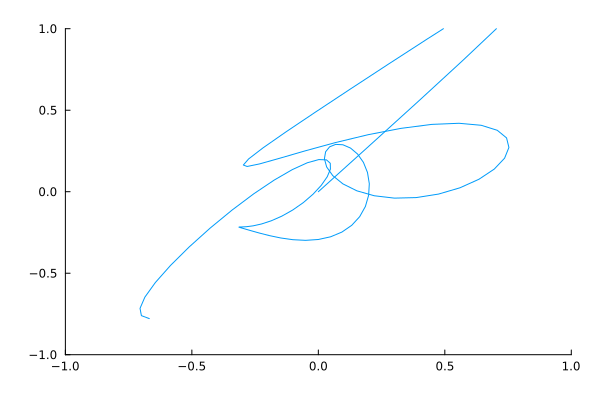

In [33]:
# Generate actions
u_A = rand(10,2)*30
u_ϕ = rand(10,2)*3
u_sim = [mean([u_A[i,1]*sin.(u_ϕ[i,1].*tsteps) for i = 1:10])' ./ 10;
         mean([u_A[i,2]*sin.(u_ϕ[i,2].*tsteps) for i = 1:10])' ./ 10]
plot(u_sim[1,:], u_sim[2,:], xlims=u_lims, ylims=u_lims)

In [67]:
# Preallocate
z_sim   = zeros(Dz,len_trial)
y_sim   = zeros(Dy,len_trial)
# F_sim   = zeros(len_trial)
preds_m = zeros(Dy,len_trial)
preds_S = repeat(diagm(ones(Dy)), outer=[1, 1, len_trial])

ybuffer = zeros(Dy,My)
ubuffer = zeros(Du,Mu+1)

Ms = zeros(Dx,Dy,len_trial)
Λs = zeros(Dx,Dx,len_trial)
Ωs = zeros(Dy,Dy,len_trial)
νs = zeros(len_trial)

# Fix starting state
z_sim[:,1] = z_0
y_sim[:,1] = emit(fbot, z_sim[:,1])
ybuffer = backshift(ybuffer,y_sim[:,1])
ubuffer = backshift(ubuffer,u_sim[:,1])
Ms[:,:,1] = M0
Λs[:,:,1] = Λ0
Ωs[:,:,1] = Ω0
νs[1] = ν0

for k in 2:len_trial

    """Make predictions"""

    x_k = [ybuffer[:]; ubuffer[:]]
    η,μ,Σ = posterior_predictive(x_k,Ms[:,:,k-1],Λs[:,:,k-1],Ωs[:,:,k-1],νs[k-1],Dx,Dy)
    preds_m[:,k] = μ
    preds_S[:,:,k] = Σ*η/(η-2)

    """Update beliefs"""

    # Update system with action
    y_sim[:,k], z_sim[:,k] = update(fbot, z_sim[:,k-1], u_sim[:,k])

    # Update input buffer
    ubuffer = backshift(ubuffer,u_sim[:,k])

    # Update MARX parameter belief
    results = infer(
        model = MARX_learning(y_kmin1 = ybuffer[:,1],
                              y_kmin2 = ybuffer[:,2],
                              u_k     = ubuffer[:,1],
                              u_kmin1 = ubuffer[:,2],
                              u_kmin2 = ubuffer[:,3],
                              M_kmin1 = Ms[:,:,k-1],
                              Λ_kmin1 = Λs[:,:,k-1],
                              Ω_kmin1 = Ωs[:,:,k-1],
                              ν_kmin1 = νs[k-1]),
        data = (y_k = y_sim[:,k],),
    )

    # Track belief
    Ms[:,:,k],Λs[:,:,k],Ωs[:,:,k],νs[k] = params(results.posteriors[:Φ])

    # Update output buffer
    ybuffer = backshift(ybuffer,y_sim[:,k])

end

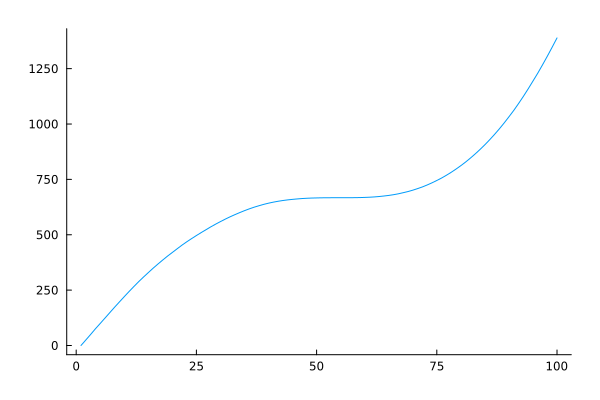

In [48]:
plot(Λs[1,1,:])

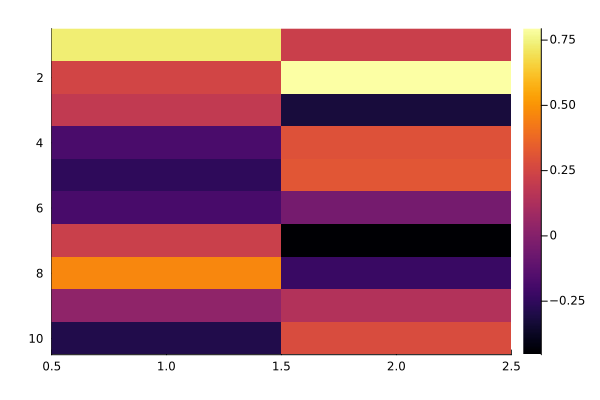

In [49]:
heatmap(Ms[:,:,end], yflip=true)

In [51]:
# twin = 10:len_trial
# plot(tsteps[twin], F_sim[twin], xlabel="time (t)", ylabel="free energy", xscale=:log10)

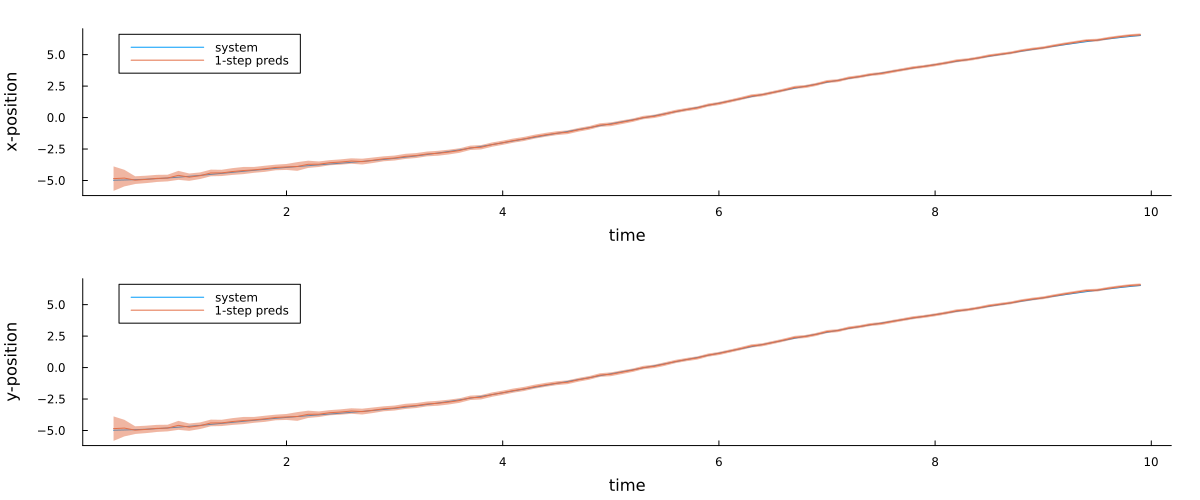

In [63]:
twin = 5:len_trial

p101 = plot(xlabel="time", ylabel="x-position")
plot!(tsteps[twin],z_sim[1,twin], label="system")
plot!(tsteps[twin],preds_m[1,twin], ribbon=sqrt.(preds_S[1,1,twin]), label="1-step preds")

p102 = plot(xlabel="time", ylabel="y-position")
plot!(tsteps[twin],z_sim[1,twin], label="system")
plot!(tsteps[twin],preds_m[1,twin], ribbon=sqrt.(preds_S[2,2,twin]), label="1-step preds")

plot(p101,p102, layout=(2,1), size=(1200,500))

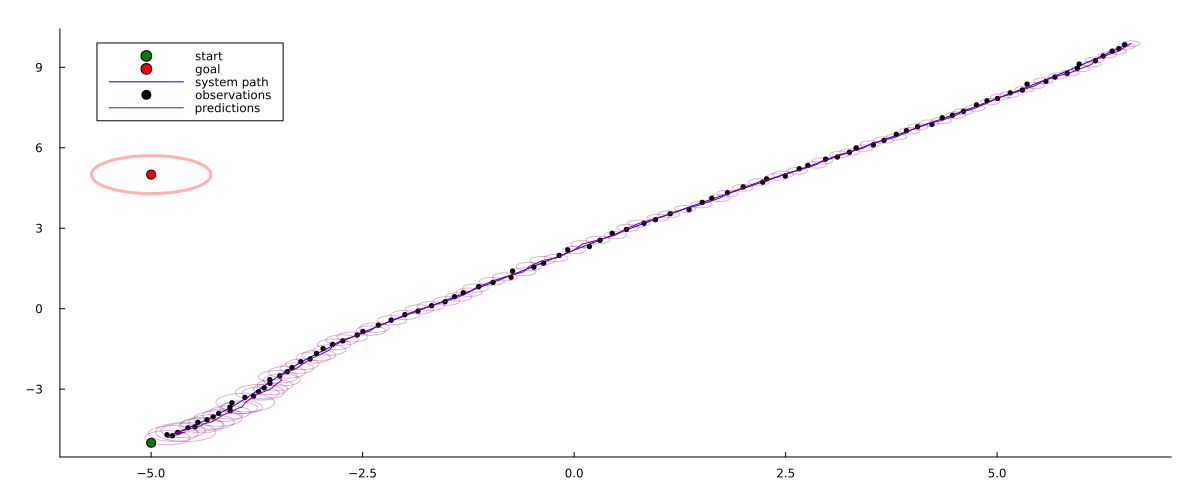

In [65]:
twin = 10:len_trial

scatter([z_0[1]], [z_0[2]], label="start", color="green", markersize=5)
scatter!([mean(goal)[1]], [mean(goal)[2]], label="goal", color="red", markersize=5)
covellipse!(mean(goal), cov(goal), n_std=1., linewidth=3, fillalpha=0.01, linecolor="red", color="red")
plot!(z_sim[1,twin], z_sim[2,twin], label="system path", color="blue")
scatter!(y_sim[1,twin], y_sim[2,twin], label="observations", color="black")

plot!(preds_m[1,twin], preds_m[2,twin], label="predictions", color="purple")
for kk = twin
    covellipse!(preds_m[:,kk], preds_S[:,:,kk], n_std=1, fillalpha=0.001, linecolor="purple", color="purple")
end
plot!(size=(1200,500))
# plot!(aspect_ratio=:equal, xlims=(-1,1), ylims=(-1,1))

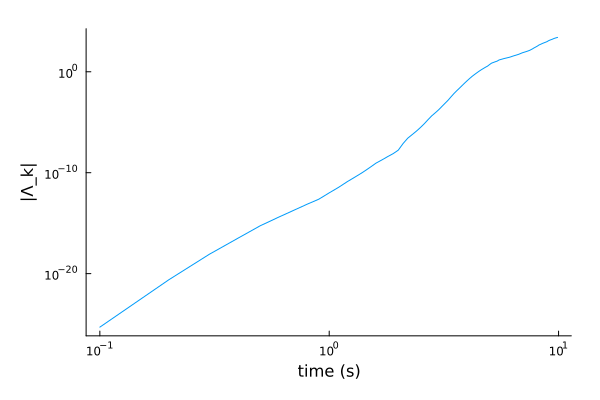

In [53]:
plot(tsteps[2:len_trial], [det(Λs[:,:,kk]) for kk in 2:len_trial], xlabel="time (s)", ylabel="|Λ_k|", xscale=:log10, yscale=:log10)

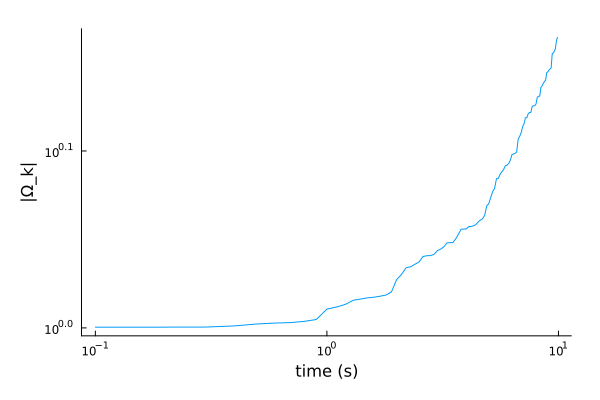

In [54]:
plot(tsteps[2:len_trial], [det(Ωs[:,:,kk]) for kk in 2:len_trial], xlabel="time (s)", ylabel="|Ω_k|", xscale=:log10, yscale=:log10)

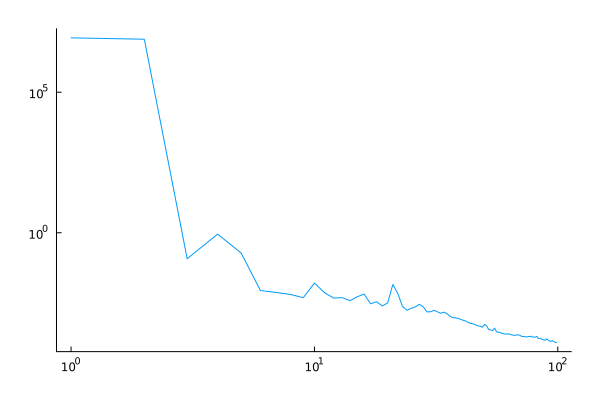

In [55]:
plot([det(preds_S[:,:,kk]) for kk in 2:len_trial], xscale=:log10, yscale=:log10)

### Active inference

In [ ]:
@model function MARX_planning(y_tmin1,y_tmin2,u_t,u_tmin1,u_tmin2, M_k,Λ_k,Ω_k,ν_k, m_star,S_star)
    "1-step ahead planning"

    # Action prior
    u_t ~ MvNormalMeanPrecision(zeros(Du),Υ)

    # Prior distribution over MARX parameters
    Φ   ~ MatrixNormalWishart(M_k, Λ_k, Ω_k, ν_k)

    # MARX Likelihood
    y_t ~ MARX(y_tmin1,y_tmin2,u_t,u_tmin1,u_tmin2,Φ)

    # Goal prior
    y_t ~ MvNormalMeanCovariance(m_star,S_star)

end

In [28]:
# Time
Δt = 0.1
len_trial = 50
tsteps = range(0, step=Δt, length=len_trial)
len_horizon = 3;

In [29]:
# Start agent
# agent = MARXAgent(M_,Λ_,Ω_,ν_,Υ, goal, Dy=Dy, Du=Du, delay_inp=Mu, delay_out=My, time_horizon=len_horizon)
agent = MARXAgent(M0,Λ0,Ω0,ν0,Υ, goal, Dy=Dy, Du=Du, delay_inp=Mu, delay_out=My, time_horizon=len_horizon)

# Preallocate
y_pln  = (zeros(len_trial, Dy,len_horizon), zeros(len_trial, Dy,Dy,len_horizon))
z_sim  = zeros(Dz,len_trial)
y_sim  = zeros(Dy,len_trial)
u_sim  = zeros(Du,len_trial)
F_sim  = zeros(len_trial)
preds_m = zeros(Dy,len_trial)
preds_S = repeat(diagm(ones(Dy)), outer=[1, 1, len_trial])

Ms = zeros(Dx,Dy,len_trial)
Λs = zeros(Dx,Dx,len_trial)
Ωs = zeros(Dy,Dy,len_trial)
νs = zeros(len_trial)

Nu = 21
ur = range(u_lims[1], stop=u_lims[2], length=Nu)
ux,uy = meshgrid(ur,ur)
uu = [ux[:]'; uy[:]']
Ju = zeros(Nu^2, len_trial)
CE = zeros(Nu^2, len_trial)
MI = zeros(Nu^2, len_trial)

# Initial state
z_sim[:,1] = z_0

policy = zeros(Du*len_horizon)

for k in 2:len_trial

    "Predict observation"
    
    x_k = [agent.ubuffer[:]; agent.ybuffer[:]]
    η,μ,Ψ = posterior_predictive(agent, x_k)
    preds_m[:,k] = μ
    preds_S[:,:,k] = inv(Ψ) * η/(η - 2)
    
    "Interact with environment"

    # Update system with selected control
    y_sim[:,k], z_sim[:,k] = update(fbot, z_sim[:,k-1], u_sim[:,k-1])
               
    "Parameter estimation"

    # Update parameters
    MARXAgents.update!(agent, y_sim[:,k], u_sim[:,k-1])

    Ms[:,:,k] = agent.M
    Λs[:,:,k] = agent.Λ
    Ωs[:,:,k] = agent.Ω
    νs[k]     = agent.ν

    # Track free energy
    F_sim[k] = agent.free_energy
    
    "Planning"
    
    # Visualize objective
    for ii in 1:Nu^2
      
        ub = MARXAgents.backshift(agent.ubuffer, uu[:,ii])
        xx = [ub[:]; agent.ybuffer[:]]
        η,μ,Ψ = posterior_predictive(agent, xx)
        MI[ii,k] = mutualinfo(agent, (η,μ,Ψ))
        CE[ii,k] = crossentropy(agent, (η,μ,Ψ))
        Ju[ii,k] = MI[ii,k] + CE[ii,k]

    end
    
    # Call minimizer using constrained L-BFGS procedure
    G(u::AbstractVector) = EFE_collapsed(agent, u)
    results = Optim.optimize(G, u_lims[1], u_lims[2], zeros(Du*len_horizon), Fminbox(LBFGS()), opts; autodiff=:forward)
    
    # Extract minimizing control
    policy = Optim.minimizer(results)
    u_sim[:,k] = policy[1:Du]

    # # Planning under optimized policy
    planned_obs = predictions(agent, reshape(policy, (Du,len_horizon)), time_horizon=len_horizon)
    y_pln[1][k,:,:]   = planned_obs[1]
    y_pln[2][k,:,:,:] = planned_obs[2]
    
end

In [30]:
jldsave("results/MARXEFE-botnav-trialnum$trialnum.jld2"; agent, F_sim, z_sim, u_sim, y_sim, y_pln, Ju, MI, CE, Ms, Λs, Ωs, νs, Υ)

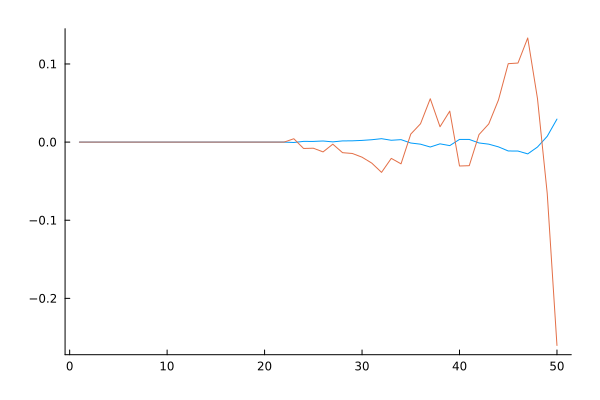

In [31]:
plot(u_sim')

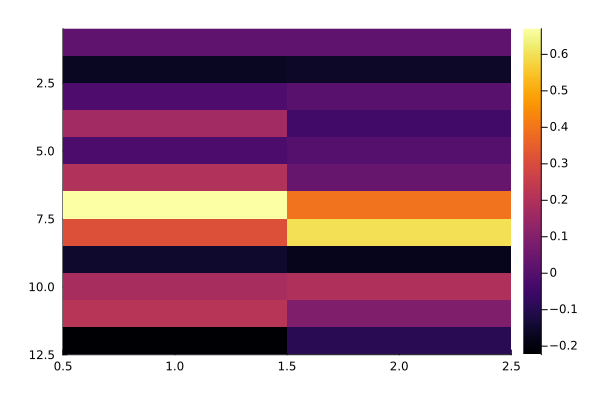

In [32]:
heatmap(Ms[:,:,end], yflip=true)

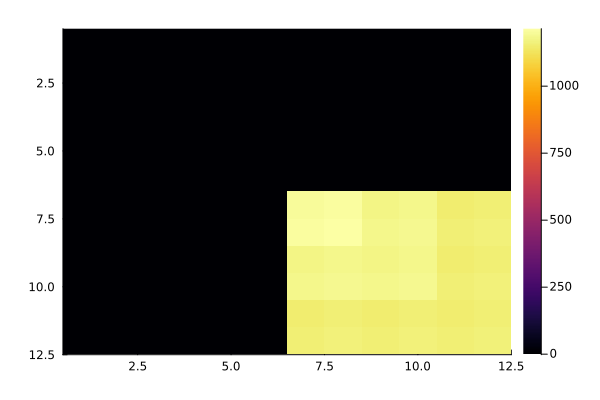

In [33]:
heatmap(Λs[:,:,end], yflip=true)

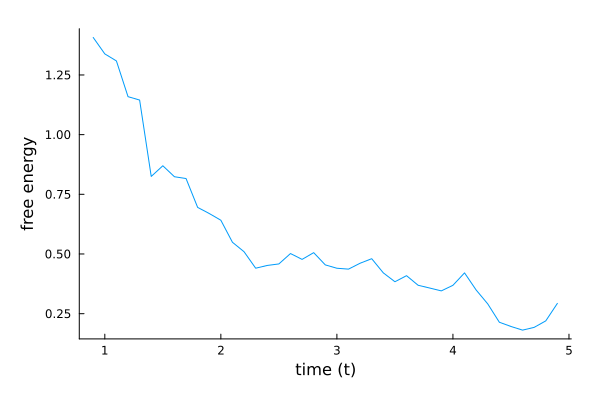

In [34]:
twin = 10:len_trial
plot(tsteps[twin], F_sim[twin], xlabel="time (t)", ylabel="free energy")

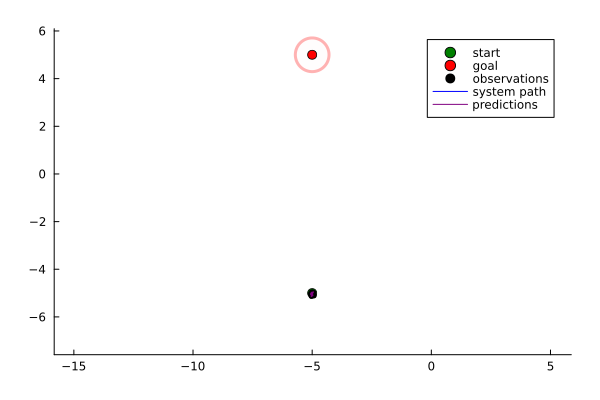

In [35]:
# twin = len_trial-1000:2:len_trial
twin = 10:len_trial

scatter([z_0[1]], [z_0[2]], label="start", color="green", markersize=5)
scatter!([mean(goal)[1]], [mean(goal)[2]], label="goal", color="red", markersize=5)
covellipse!(mean(goal), cov(goal), n_std=1., linewidth=3, fillalpha=0.01, linecolor="red", color="red")
scatter!(y_sim[1,twin], y_sim[2,twin], label="observations", color="black")
plot!(z_sim[1,twin], z_sim[2,twin], label="system path", color="blue")

for kk = twin
    covellipse!(preds_m[:,kk], preds_S[:,:,kk], n_std=1, alpha=0.001, fillalpha=0.0001, color="purple")
end
plot!(preds_m[1,twin], preds_m[2,twin], label="predictions", color="purple")
plot!(aspect_ratio=:equal)
# plot!(xlims=(-3,3), ylims=(-3,3))

In [36]:
function trackbot(tk)

    xl = extrema(y_sim[1,:])
    yl = extrema(y_sim[2,:])
    ttime = round(tk*Δt, digits=1)
    plot(title="time = $ttime sec", xlims=xl, ylims=yl)

    scatter!([z_0[1]], [z_0[2]], label="start", color="green", markersize=5)
    scatter!([mean(goal)[1]], [mean(goal)[2]], label="goal", color="red", markersize=5)
    covellipse!(mean(goal), cov(goal), n_std=1., linewidth=3, fillalpha=0.01, linecolor="red", color="red")
    scatter!([y_sim[1,tk]], [y_sim[2,tk]], alpha=0.3, label="observations", color="black")
    plot!([z_sim[1,tk]], [z_sim[2,tk]], marker=:star5, markersize=5, label="system path", color="blue")
   
    for kk = 1:len_horizon
        covellipse!(y_pln[1][tk,:,kk], y_pln[2][tk,:,:,kk]/100, linewidth=0, n_std=1, fillalpha=0.1, color="orange")
    end
    plot!(y_pln[1][tk,1,:], y_pln[1][tk,2,:], color="orange", label="planning")

end

trackbot (generic function with 1 method)

┌ Info: Saved animation to /home/synd/Wouter/Onderzoek/Projecten/tue/efe-acquisition/narx-efe/notebooks/figures/MARXEFE-botnav-trialnum81.gif
└ @ Plots /home/wmkouw/.julia/packages/Plots/Ec1L1/src/animation.jl:156


Plots.AnimatedGif("/home/synd/Wouter/Onderzoek/Projecten/tue/efe-acquisition/narx-efe/notebooks/figures/MARXEFE-botnav-trialnum81.gif")
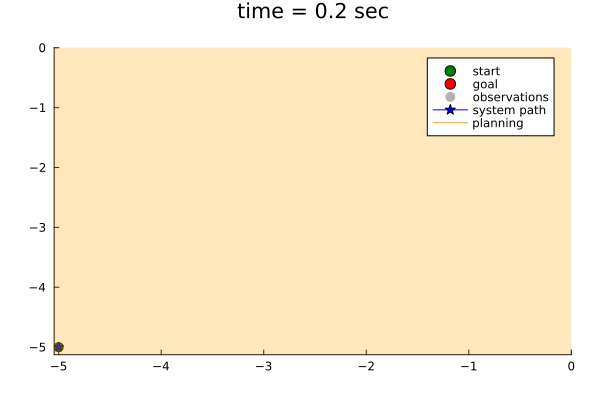

In [37]:
anim = @animate for tt in 2:len_trial
    trackbot(tt)
end
gif(anim, "figures/MARXEFE-botnav-trialnum$trialnum.gif", fps=3/Δt)

In [133]:
# tk = len_trial-10 # > 1

# # scatter([z_0[1]], [z_0[2]], label="start", color="green", markersize=5)
# scatter([mean(goal)[1]], [mean(goal)[2]], label="goal", color="red", markersize=5)
# covellipse!(mean(goal), cov(goal), n_std=1., linewidth=3, fillalpha=0.01, linecolor="red", color="red")
# scatter!([z_sim[1,tk]], [z_sim[2,tk]], label="system path", color="blue")
# scatter!([y_sim[1,tk]], [y_sim[2,tk]], label="observations", color="black")

# for kk = 1:len_horizon
#     covellipse!(y_pln[1][tk,:,kk], y_pln[2][tk,:,:,kk], n_std=1, linewidth=0, fillalpha=0.2, color="orange")
# end
# plot!(y_pln[1][tk,1,:], y_pln[1][tk,2,:], color="orange", label="planning")

# # plot!(xlims=(-2,2), ylims=(-2,2))
# # plot!(xlims=(-10,10), ylims=(-10,10))